# HealingNYC
## MTA and opioid analysis

In [344]:
import pandas as pd
import datetime
import geopandas
from shapely import wkt

### **MTA data cleaning**

Load in data from website directory

In [6]:
# Source: http://web.mta.info/developers/turnstile.html
def get_data(week_nums,local=False):
    if local:
        url = "turnstile_{}.txt"
    else:
        url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)


week_nums = [210703, 210710,210717,210724,210731,210807, 210814,210821,210828,210904,210911,210918,210925]
turnstiles_df = get_data(week_nums,local=True)

In [7]:
turnstiles_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/26/2021,00:00:00,REGULAR,7592792,2595706
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/26/2021,04:00:00,REGULAR,7592804,2595713
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/26/2021,08:00:00,REGULAR,7592816,2595729
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/26/2021,12:00:00,REGULAR,7592870,2595762
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/26/2021,16:00:00,REGULAR,7592992,2595791


In [8]:
turnstiles_df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES',
       'EXITS                                                               '],
      dtype='object')

In [9]:
turnstiles_df.columns = [column.strip() for column in turnstiles_df.columns]
turnstiles_df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')

In [375]:
# Three months of Data
turnstiles_df.DATE.value_counts().sort_index()

turnstiles_df[turnstiles_df.STATION == "CITY / BUS"]

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,ENTRIES,DATE_TIME
122674,PTH07,R550,00-02-04,CITY / BUS,1,PTH,09/24/2021,20:13:26,10305,2021-09-24 20:13:26
122673,PTH07,R550,00-02-04,CITY / BUS,1,PTH,09/24/2021,16:01:26,10305,2021-09-24 16:01:26
122672,PTH07,R550,00-02-04,CITY / BUS,1,PTH,09/24/2021,11:49:26,10305,2021-09-24 11:49:26
122671,PTH07,R550,00-02-04,CITY / BUS,1,PTH,09/24/2021,07:37:26,10302,2021-09-24 07:37:26
122670,PTH07,R550,00-02-04,CITY / BUS,1,PTH,09/24/2021,03:25:26,10301,2021-09-24 03:25:26
...,...,...,...,...,...,...,...,...,...,...
122370,PTH07,R550,00-00-00,CITY / BUS,1,PTH,06/26/2021,17:31:20,167039,2021-06-26 17:31:20
122369,PTH07,R550,00-00-00,CITY / BUS,1,PTH,06/26/2021,13:19:20,166991,2021-06-26 13:19:20
122368,PTH07,R550,00-00-00,CITY / BUS,1,PTH,06/26/2021,09:07:20,166956,2021-06-26 09:07:20
122367,PTH07,R550,00-00-00,CITY / BUS,1,PTH,06/26/2021,04:55:20,166955,2021-06-26 04:55:20


In [12]:
# Take the date and time fields into a single datetime column
turnstiles_df["DATE_TIME"] = pd.to_datetime(turnstiles_df.DATE + " " + turnstiles_df.TIME, 
                                            format="%m/%d/%Y %H:%M:%S")

In [13]:
turnstiles_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/26/2021,00:00:00,REGULAR,7592792,2595706,2021-06-26 00:00:00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/26/2021,04:00:00,REGULAR,7592804,2595713,2021-06-26 04:00:00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/26/2021,08:00:00,REGULAR,7592816,2595729,2021-06-26 08:00:00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/26/2021,12:00:00,REGULAR,7592870,2595762,2021-06-26 12:00:00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/26/2021,16:00:00,REGULAR,7592992,2595791,2021-06-26 16:00:00


In [14]:
# There are multiple entries for a combination of "C/A", "UNIT", "SCP", "STATION", "DATE_TIME"
(turnstiles_df
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head(5)

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
2702968,S101,R070,00-00-02,ST. GEORGE,2021-09-16 08:00:00,2
2702884,S101,R070,00-00-02,ST. GEORGE,2021-09-02 16:00:00,2
2455849,R516,R291,00-00-00,33 ST-RAWSON ST,2021-08-24 16:00:00,2
1390007,N535,R220,00-00-01,CARROLL ST,2021-08-31 16:00:00,2
1389458,N535,R220,00-00-00,CARROLL ST,2021-08-31 16:00:00,2


In [15]:
#It's due multiple RECOVR AUD readings, rather than REGULAR (normally scheduled one)

turnstiles_df.DESC.value_counts()

REGULAR       2710251
RECOVR AUD      14167
Name: DESC, dtype: int64

In [16]:
# Remove of duplicate entries
turnstiles_df.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], 
                          inplace=True, ascending=False)
turnstiles_df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)

In [17]:
# Now there are no duplicate entries
(turnstiles_df
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head(5)

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
0,A002,R051,02-00-00,59 ST,2021-06-26 00:00:00,1
1816191,R139,R031,04-00-00,34 ST-PENN STA,2021-09-05 12:00:00,1
1816193,R139,R031,04-00-00,34 ST-PENN STA,2021-09-05 20:00:00,1
1816194,R139,R031,04-00-00,34 ST-PENN STA,2021-09-06 00:00:00,1
1816195,R139,R031,04-00-00,34 ST-PENN STA,2021-09-06 04:00:00,1


In [18]:
# Drop Exits and Desc Column.  To prevent errors in multiple run of cell, errors on drop is ignored
turnstiles_df = turnstiles_df.drop(["EXITS", "DESC"], axis=1, errors="ignore")

Find the daily number of entries by turnstile

In [19]:
turnstiles_daily = (turnstiles_df
                        .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"],as_index=False)
                        .ENTRIES.first())

turnstiles_daily[["PREV_DATE", "PREV_ENTRIES"]] = (turnstiles_daily
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION"])[["DATE", "ENTRIES"]]
                                                       .apply(lambda grp: grp.shift(1)))

In [20]:
turnstiles_daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
0,A002,R051,02-00-00,59 ST,06/26/2021,7593116,NaN,NaN
1,A002,R051,02-00-00,59 ST,06/27/2021,7593427,06/26/2021,7593116.0
2,A002,R051,02-00-00,59 ST,06/28/2021,7593979,06/27/2021,7593427.0
3,A002,R051,02-00-00,59 ST,06/29/2021,7594528,06/28/2021,7593979.0
4,A002,R051,02-00-00,59 ST,06/30/2021,7595154,06/29/2021,7594528.0


In [21]:
turnstiles_daily.tail()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
454570,TRAM2,R469,00-05-01,RIT-ROOSEVELT,09/20/2021,5554,09/19/2021,5554.0
454571,TRAM2,R469,00-05-01,RIT-ROOSEVELT,09/21/2021,5554,09/20/2021,5554.0
454572,TRAM2,R469,00-05-01,RIT-ROOSEVELT,09/22/2021,5554,09/21/2021,5554.0
454573,TRAM2,R469,00-05-01,RIT-ROOSEVELT,09/23/2021,5554,09/22/2021,5554.0
454574,TRAM2,R469,00-05-01,RIT-ROOSEVELT,09/24/2021,5554,09/23/2021,5554.0


In [22]:
# Drop the rows for the earliest date in the df
turnstiles_daily.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

### Reverse Entries

Next, let's look at some more weirdness in the data and think about handling it before we finalize our daily count column

In [23]:
turnstiles_daily[turnstiles_daily["ENTRIES"] < turnstiles_daily["PREV_ENTRIES"]].head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
3550,A011,R080,01-03-00,57 ST-7 AV,06/27/2021,885594879,06/26/2021,885595097.0
3551,A011,R080,01-03-00,57 ST-7 AV,06/28/2021,885594609,06/27/2021,885594879.0
3552,A011,R080,01-03-00,57 ST-7 AV,06/29/2021,885594336,06/28/2021,885594609.0
3553,A011,R080,01-03-00,57 ST-7 AV,06/30/2021,885594053,06/29/2021,885594336.0
3554,A011,R080,01-03-00,57 ST-7 AV,07/01/2021,885593780,06/30/2021,885594053.0


* Counter working in Reverse??? 

In [24]:
# Let's see how many stations have this problem

(turnstiles_daily[turnstiles_daily["ENTRIES"] < turnstiles_daily["PREV_ENTRIES"]]
    .groupby(["C/A", "UNIT", "SCP", "STATION"])
    .size())

C/A   UNIT  SCP       STATION        
A011  R080  01-03-00  57 ST-7 AV         90
A013  R081  01-06-01  49 ST               1
A014  R081  02-00-00  49 ST               1
A049  R088  02-05-00  CORTLANDT ST       23
A066  R118  00-00-00  CANAL ST           90
                                         ..
R622  R123  00-00-00  FRANKLIN AV        90
R633  R068  00-00-01  VAN SICLEN AV       1
R646  R110  01-00-02  FLATBUSH AV-B.C     1
R730  R431  00-00-04  EASTCHSTER/DYRE    89
S101  R070  00-00-02  ST. GEORGE          5
Length: 198, dtype: int64

In [25]:
def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

# If counter is > 1Million, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits
# It'd probably be a good idea to use a number even significantly smaller than 1 million as the limit!
turnstiles_daily["DAILY_ENTRIES"] = turnstiles_daily.apply(get_daily_counts, axis=1, max_counter=1000000)

353 8049630.0
167790157 702266.0
310 5609562.0
35 9768753.0
33565227 188178.0
48 8724126.0
511 3272795.0
5946 4298704.0
0 117440512.0
327975 7577027.0
67109632 14.0
327682 67109640.0
15 67109632.0
36 1198448.0
46 5405351.0
200 705357551.0
16777220 1037157.0
6 16034831.0
386 6213955.0
37 1950780.0
443 15689395.0
8 1255797.0
5 11123659.0
256 3153907.0
126 3102523.0
19 2570919.0
50362839 251769.0
114 1953264.0
169 4788322.0
82 6249985.0
67 1040931923.0
118 909043641.0
197214 1890967.0
716 3145979.0
285 3530461.0
35 10737302.0
201331968 798740.0
154 5768873.0
1089962154 146746170.0
3539010 51735353.0
124 2030205.0
112 7682427.0
1189019240 3740789.0
346167 14045092.0
14051313 346213.0
774447 9475375.0
9482240 774522.0
7979566 789214.0
796277 7979671.0
1278449 8197329.0
8205884 1278639.0
635 4005927.0
4006679 635.0
113 1684097.0
327683 50346231.0
41 6481415.0
92 1383110115.0


In [26]:
turnstiles_daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES
1,A002,R051,02-00-00,59 ST,06/27/2021,7593427,06/26/2021,7593116.0,311.0
2,A002,R051,02-00-00,59 ST,06/28/2021,7593979,06/27/2021,7593427.0,552.0
3,A002,R051,02-00-00,59 ST,06/29/2021,7594528,06/28/2021,7593979.0,549.0
4,A002,R051,02-00-00,59 ST,06/30/2021,7595154,06/29/2021,7594528.0,626.0
5,A002,R051,02-00-00,59 ST,07/01/2021,7595703,06/30/2021,7595154.0,549.0


Group now by groups of turnstiles (so one compination of C/A, UNIT, STATION)

In [27]:
ca_unit_station_daily = turnstiles_daily.groupby(["C/A", "UNIT", "STATION", "DATE"])[['DAILY_ENTRIES']].sum().reset_index()
ca_unit_station_daily.head()

,C/A,UNIT,STATION,DATE,DAILY_ENTRIES
0,A002,R051,59 ST,06/27/2021,2499.0
1,A002,R051,59 ST,06/28/2021,4569.0
2,A002,R051,59 ST,06/29/2021,4842.0
3,A002,R051,59 ST,06/30/2021,5016.0
4,A002,R051,59 ST,07/01/2021,4803.0


Find number of entires for each station for each day

In [28]:
station_daily = turnstiles_daily.groupby(["STATION", "DATE"])[['DAILY_ENTRIES']].sum().reset_index()
station_daily.head()

,STATION,DATE,DAILY_ENTRIES
0,1 AV,06/27/2021,6835.0
1,1 AV,06/28/2021,7529.0
2,1 AV,06/29/2021,7231.0
3,1 AV,06/30/2021,7588.0
4,1 AV,07/01/2021,7687.0


Find the total number of entries over the three months of data we have for each station.

Then sort to find the top 10 most trafficed stations over this time period.

In [258]:
station_totals = station_daily.groupby('STATION').sum()\
    .sort_values('DAILY_ENTRIES', ascending=False)\
    .reset_index()

station_totals.head(20)

,STATION,DAILY_ENTRIES
0,JUNCTION BLVD,5598373.0
1,34 ST-PENN STA,4878624.0
2,FULTON ST,3854879.0
3,86 ST,3490332.0
4,PATH NEW WTC,3355018.0
5,34 ST-HERALD SQ,3079289.0
6,GRD CNTRL-42 ST,2996768.0
7,42 ST-PORT AUTH,2777623.0
8,72 ST,2775741.0
9,23 ST,2633567.0


### **Opioid mortality data**



In [30]:
#Source can be found at https://www.health.ny.gov/statistics/opioid/

local = True
if local:
    url = "OP-CountyTrendData.xlsx"
else:
    url = "https://webbi1.health.ny.gov/SASStoredProcess/DOHSTAT/dohPublic/pix/OP-CountyTrendData.xlsx"
    
#Skip top 2 blank lines, verify this if source is updated
op_raw = pd.read_excel(url, header =2)
op_raw.head(2)

,County Name,Priority Area Number,Priority Area,Indicator Number,Indicator,Event Count/Rate,Average Number of Denominator/Rate,Percentage/Rate/Ratio,Lower Limit of 95% CI,Upper Limit of 95% CI,Data Comments,Data Years,Date Source
0,Albany,1,Opioid Data Overview,op51,"Overdose deaths involving any opioid, crude ra...",15,304078.0,4.9,NaN,NaN,NaN,2010,Vital Statistics Data as of August 2020
1,Allegany,1,Opioid Data Overview,op51,"Overdose deaths involving any opioid, crude ra...",3,48962.0,6.1,NaN,NaN,Unstable Estimate,2010,Vital Statistics Data as of August 2020


In [31]:
#Data contains counts for various opioid-related events

print(op_raw.Indicator.unique()[0:4])
print(len(op_raw.Indicator.unique()))

['Overdose deaths involving any opioid, crude rate per 100,000 population'
 'Unique naloxone administrations by EMS agencies, crude rate per 1,000 unique 911 EMS dispatches'
 'Opioid analgesics prescription, crude rate per 1,000 population'
 'Opioid analgesics prescription, age-adjusted rate per 1,000 population']
66


Focus on overdose deaths due to opioid (per 100,000)

In [32]:
op_df = op_raw[op_raw.Indicator == "Overdose deaths involving any opioid, crude rate per 100,000 population"]
op_df.head(2)

,County Name,Priority Area Number,Priority Area,Indicator Number,Indicator,Event Count/Rate,Average Number of Denominator/Rate,Percentage/Rate/Ratio,Lower Limit of 95% CI,Upper Limit of 95% CI,Data Comments,Data Years,Date Source
0,Albany,1,Opioid Data Overview,op51,"Overdose deaths involving any opioid, crude ra...",15,304078.0,4.9,NaN,NaN,NaN,2010,Vital Statistics Data as of August 2020
1,Allegany,1,Opioid Data Overview,op51,"Overdose deaths involving any opioid, crude ra...",3,48962.0,6.1,NaN,NaN,Unstable Estimate,2010,Vital Statistics Data as of August 2020


Each row is the data for one county for one year. This data is for the whole state of New York, but each borough of NYC is a county, so we can use that.

Now choose the columns of interest, in particular:

- Name of the county, which is the borough
- Raw count of deaths due to opioid overdoes
- Population
- Deaths due to opioid overdoes per 100000 population
- Year


In [33]:
op_df = op_df.loc[:,["County Name", "Event Count/Rate", "Average Number of Denominator/Rate", 
                    "Percentage/Rate/Ratio", "Data Years", "Data Comments"]]

col_dict = {"County Name":"county", "Event Count/Rate":"death_count", "Average Number of Denominator/Rate":"pop",
           "Percentage/Rate/Ratio":"deaths_per_100k","Data Years":"year", "Data Comments":"notes"}

op_df.rename(columns = col_dict, inplace=True)
op_df.head()

,county,death_count,pop,deaths_per_100k,year,notes
0,Albany,15,304078.0,4.9,2010,NaN
1,Allegany,3,48962.0,6.1,2010,Unstable Estimate
2,Broome,10,200478.0,5,2010,NaN
3,Cattaraugus,1,80230.0,1.2,2010,Unstable Estimate
4,Cayuga,7,79901.0,8.8,2010,Unstable Estimate


Choose only the rows corresponding to NYC boroughs

In [34]:
#Dictionary maps county name to Borough name
county2boro = {"Bronx":"Bronx","New York":"Manhattan","Queens":"Queens","Richmond":"Staton Island"
               ,"Kings":"Brooklyn"}

op_df = op_df[op_df.county.isin(county2boro.keys())]
op_df.shape

(90, 6)

In [35]:
op_df.groupby(["county","year"]).pop.count()

county    year
Bronx     2010    2
          2011    2
          2012    2
          2013    2
          2014    2
          2015    2
          2016    2
          2017    2
          2018    2
Kings     2010    2
          2011    2
          2012    2
          2013    2
          2014    2
          2015    2
          2016    2
          2017    2
          2018    2
New York  2010    2
          2011    2
          2012    2
          2013    2
          2014    2
          2015    2
          2016    2
          2017    2
          2018    2
Queens    2010    2
          2011    2
          2012    2
          2013    2
          2014    2
          2015    2
          2016    2
          2017    2
          2018    2
Richmond  2010    2
          2011    2
          2012    2
          2013    2
          2014    2
          2015    2
          2016    2
          2017    2
          2018    2
Name: pop, dtype: int64

There are two rows for each borough/year (different data sources). Remove the duplicate rows.

In [36]:
op_df.drop_duplicates(inplace=True)
op_df.shape

(45, 6)

Add a column for the borough name

In [37]:
op_df["boro"] = op_df.county.map(county2boro)
op_df.head()

,county,death_count,pop,deaths_per_100k,year,notes,boro
57,Bronx,71,1387353.0,5.1,2010,NaN,Bronx
58,Kings,130,2509877.0,5.2,2010,NaN,Brooklyn
59,New York,50,1588759.0,3.1,2010,NaN,Manhattan
60,Queens,87,2234745.0,3.9,2010,NaN,Queens
61,Richmond,47,469621.0,10,2010,NaN,Staton Island


### **Geodata for NY boroughs**

Access the geodata for NYC boroughs from Geopandas.

In [40]:
boro_path = geopandas.datasets.get_path("nybb")
boro_df = geopandas.read_file(boro_path)
boro_df.set_index("BoroName", inplace=True)

boro_df

,BoroCode,Shape_Leng,Shape_Area,geometry
BoroName,,,,
Staten Island,5,330470.010332,1.623820e+09,"MULTIPOLYGON (((970217.022 145643.332, 970227...."
Queens,4,896344.047763,3.045213e+09,"MULTIPOLYGON (((1029606.077 156073.814, 102957..."
Brooklyn,3,741080.523166,1.937479e+09,"MULTIPOLYGON (((1021176.479 151374.797, 102100..."
Manhattan,1,359299.096471,6.364715e+08,"MULTIPOLYGON (((981219.056 188655.316, 980940...."
Bronx,2,464392.991824,1.186925e+09,"MULTIPOLYGON (((1012821.806 229228.265, 101278..."


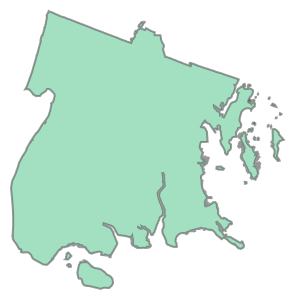

In [41]:
boro_df.loc["Bronx","geometry"]

In [42]:
boro_df_loglat = boro_df.to_crs("EPSG:4326")
boro_df_loglat

,BoroCode,Shape_Leng,Shape_Area,geometry
BoroName,,,,
Staten Island,5,330470.010332,1.623820e+09,"MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ..."
Queens,4,896344.047763,3.045213e+09,"MULTIPOLYGON (((-73.83668 40.59495, -73.83678 ..."
Brooklyn,3,741080.523166,1.937479e+09,"MULTIPOLYGON (((-73.86706 40.58209, -73.86769 ..."
Manhattan,1,359299.096471,6.364715e+08,"MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ..."
Bronx,2,464392.991824,1.186925e+09,"MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ..."


### **Station location data**

Now we get the geodata for locations of the station entrances.

In [330]:
#Source: https://data.cityofnewyork.us/api/views/kk4q-3rt2/rows.csv
local = True

if local:
    url = "station_location.csv"
else:
    url= "https://data.cityofnewyork.us/api/views/kk4q-3rt2/rows.csv"
    
stations_df = geopandas.read_file(url)
stations_df.head()

,URL,OBJECTID,NAME,the_geom,LINE,NOTES,geometry
0,http://web.mta.info/nyct/service/,1,Astor Pl,POINT (-73.99106999861966 40.73005400028978),4-6-6 Express,"4 nights, 6-all times, 6 Express-weekdays AM s...",None
1,http://web.mta.info/nyct/service/,2,Canal St,POINT (-74.00019299927328 40.71880300107709),4-6-6 Express,"4 nights, 6-all times, 6 Express-weekdays AM s...",None
2,http://web.mta.info/nyct/service/,3,50th St,POINT (-73.98384899986625 40.76172799961419),1-2,"1-all times, 2-nights",None
3,http://web.mta.info/nyct/service/,4,Bergen St,POINT (-73.97499915116808 40.68086213682956),2-3-4,"4-nights, 3-all other times, 2-all times",None
4,http://web.mta.info/nyct/service/,5,Pennsylvania Ave,POINT (-73.89488591154061 40.66471445143568),3-4,"4-nights, 3-all other times",None


In [331]:
stations_df = stations_df.loc[:,["NAME","the_geom"]]
stations_df.head()

,NAME,the_geom
0,Astor Pl,POINT (-73.99106999861966 40.73005400028978)
1,Canal St,POINT (-74.00019299927328 40.71880300107709)
2,50th St,POINT (-73.98384899986625 40.76172799961419)
3,Bergen St,POINT (-73.97499915116808 40.68086213682956)
4,Pennsylvania Ave,POINT (-73.89488591154061 40.66471445143568)


In [332]:
stations_df['geometry'] = geopandas.GeoSeries.from_wkt(stations_df['the_geom'])
stations_df = stations_df.set_crs("EPSG:4326")
stations_df.dtypes

NAME          object
the_geom      object
geometry    geometry
dtype: object

In [333]:
stations_df.groupby("NAME").NAME.count().sort_values(ascending = False)

NAME
86th St          5
23rd St          5
Fulton St        5
Canal St         5
125th St         4
                ..
Beach 98th St    1
Beach 90th St    1
Beach 67th St    1
Beach 60th St    1
Zerega Ave       1
Name: NAME, Length: 355, dtype: int64

In [334]:
def find_boro(location):
    for boro in boro_df.index:
        if location.within(boro_df_loglat.loc[boro,"geometry"]):
            return boro
    return None
            

stations_df["boro"] = stations_df.geometry.apply(find_boro)

#This code checks that each station entrance is in exactly 1 borough
#for boro in boro_df.index:
#    stations_df[boro] = stations_df.geometry.apply(lambda x: x.within(boro_df_loglat.loc[boro,"geometry"]))
#    stations_df["num_in"] += stations_df["in " + boro]

#stations_df.head()

#print(stations_df.groupby("NAME").num_in.max())
#print(stations_df.num_in.min())

In [335]:
stations_df.head()

,NAME,the_geom,geometry,boro
0,Astor Pl,POINT (-73.99106999861966 40.73005400028978),POINT (-73.99107 40.73005),Manhattan
1,Canal St,POINT (-74.00019299927328 40.71880300107709),POINT (-74.00019 40.71880),Manhattan
2,50th St,POINT (-73.98384899986625 40.76172799961419),POINT (-73.98385 40.76173),Manhattan
3,Bergen St,POINT (-73.97499915116808 40.68086213682956),POINT (-73.97500 40.68086),Brooklyn
4,Pennsylvania Ave,POINT (-73.89488591154061 40.66471445143568),POINT (-73.89489 40.66471),Brooklyn


In [336]:
stations_df.drop_duplicates(subset=(["NAME", "boro"]), inplace=True)

(stations_df.groupby("NAME").NAME.count().sort_values(ascending = False) > 1).sum()

14

There are 14 stations with entrances in two different boroughs.

Create a column called boro2 that is this second borough. Then leave just one row for each station

In [337]:
stations_df["boro2"] = stations_df.groupby("NAME").boro.shift(-1)

In [338]:


stations_df.drop_duplicates(subset="NAME", keep="first", inplace=True)
stations_df.shape
stations_df.boro2.isna().sum()

341

Convert the station names in the location dataset to the same format as those in the MTA dataset.

- All caps
- Remove th, st, nd, rd after numeric street names.
- Probably some ad hoc abbreviations


In [339]:
def remove_ordinal(string):
    ordinals = ["ST", "ND", "RD", "TH"]
    for my_ord in ordinals:
        i = string.find(my_ord)
        if i !=0:
            if (string[i-1].isnumeric()):
                string = string[:i] + string[i+2:]
            
    return string

stations_df["NAME"] = stations_df.NAME.str.upper().apply(remove_ordinal)

stations_df.sample(10)

,NAME,the_geom,geometry,boro,boro2
24,FLUSHING - MAIN ST,POINT (-73.83003000262508 40.75959999915012),POINT (-73.83003 40.75960),Queens,NaN
279,WAKEFIELD - 241 ST,POINT (-73.8506199987954 40.903125000541245),POINT (-73.85062 40.90313),Bronx,NaN
445,CLARK ST,POINT (-73.99308599821961 40.69746599996469),POINT (-73.99309 40.69747),Brooklyn,NaN
215,LIVONIA AVE,POINT (-73.90056237226057 40.66405727094644),POINT (-73.90056 40.66406),Brooklyn,NaN
262,FORDHAM RD,POINT (-73.89774900102401 40.861295998683495),POINT (-73.89775 40.86130),Bronx,NaN
314,20 AVE,POINT (-73.98452199846113 40.617108999866005),POINT (-73.98452 40.61711),Brooklyn,NaN
206,85 ST - FOREST PKY,POINT (-73.86008700006875 40.69242699966103),POINT (-73.86009 40.69243),Queens,NaN
101,68 ST - HUNTER COLLEGE,POINT (-73.96387000158042 40.76814100049679),POINT (-73.96387 40.76814),Manhattan,NaN
191,GRANT AVE,POINT (-73.86504999877702 40.67704400054478),POINT (-73.86505 40.67704),Brooklyn,NaN
117,FULTON ST,POINT (-73.97537499833149 40.68711899950771),POINT (-73.97537 40.68712),Brooklyn,Manhattan


Both data sets sometimes use "AV", sometimes "AVE", and sometimes "AVENUE". We'll standardize this to "AVE"

Also replace any "/" with "-" 

Also remove . and '

In [367]:
#AV vs AVE
def av2ave(string):
    '''Replaces AV with AVE'''
    if "AV" in string:
        i = string.find("AV")
        if (i == 0 or not string[i-1].isalpha()) and (i == len(string) - 2 or not string[i+2].isalpha()):
            return string.replace("AV", "AVE")
    string = string.replace("AVENUE", "AVE") 
    return string


station_totals["NEW_NAME"] = station_totals.STATION.str.replace("/","-").apply(av2ave)
station_totals["NEW_NAME"] = station_totals.NEW_NAME.str.replace(r"'", "").str.replace(r".","")


#print(station_totals[station_totals.NEW_NAME.apply(lambda x: " AV" in x and "AVE" not in x)].NEW_NAME.count())

stations_df["NAME"] = stations_df.NAME.str.replace("/","-").apply(av2ave)
stations_df["NAME"] = stations_df.NAME.str.replace(r"'", "").str.replace(r".","")
#print(stations_df[stations_df.NAME.apply(lambda x: " AV" in x and "AVE" not in x)].NAME.count())



<ipython-input-367-83a5f3a3af60>:13: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  station_totals["NEW_NAME"] = station_totals.NEW_NAME.str.replace(r"'", "").str.replace(r".","")
<ipython-input-367-83a5f3a3af60>:19: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  stations_df["NAME"] = stations_df.NAME.str.replace(r"'", "").str.replace(r".","")


In [368]:
station_totals.NEW_NAME.isin(stations_df.NAME).mean()

0.6147757255936676

Only about 61% of the station names in the MTA data appear in the location data. Why?

Fix some specific stations individually.

In [370]:
station_dict = {"EAST 105 ST": "E 105 ST", "40 ST LOWERY ST":"40 ST", "46 ST BLISS ST":"46 ST",
               "RIT-ROOSEVELT":"JACKSON HTS - ROOSEVELT AVE", "PATH NEW WTC":"WORLD TRADE CENTER",
               "PATH WTC 2":"WORLD TRADE CENTER","WTC-CORTLANDT":"CORTLANDT ST",
               "THIRTY THIRD ST":"33 ST", "TWENTY THIRD ST":"23 ST",
               "81 ST-MUSEUM":"81 ST", "JAMAICA CENTER":"JAMAICA CTR", "WHITEHALL S-FRY":"WHITEHALL ST",
               "34 ST-HERALD SQ":"HERALD SQ - 34 ST", "14 ST-UNION SQ":"UNION SQ - 14 ST", "PARK PLACE":"PARK PL",
               "QUEENSBORO PLAZA":"QUEENSBORO PLZ"}

station_totals["NEW_NAME"] = station_totals.NEW_NAME.apply(
                                lambda x: x if x not in station_dict else station_dict[x])

In [372]:
station_totals.NEW_NAME.isin(stations_df.NAME).mean()

0.6517150395778364

Still at only 65%

Some reasons:
    -New Jersey and Staten Island are missing from MTA data


In [373]:
stations_df.NAME[~stations_df.NAME.isin(station_totals.NEW_NAME)]

6              CATHEDRAL PKWY (110TH ST)
7                 KINGSTON - THROOP AVES
10                DELANCEY ST - ESSEX ST
13                           104-102 STS
20                         174-175TH STS
                     ...                
423    MIDDLE VILLAGE - METROPOLITAN AVE
432              BROADWAY - LAFAYETTE ST
465                    5 AVE - BRYANT PK
468         CONEY ISLAND - STILLWELL AVE
469                 34 ST - HUDSON YARDS
Name: NAME, Length: 114, dtype: object

Many of these names are longer and less abbreviated.

In [374]:
#Checks if b exists in a as a subsequence
def subseq(a, b):
    pos = 0
    for ch in a:
        if pos < len(b) and ch == b[pos]:
            pos += 1
    return pos == len(b)

num_matches = station_totals[~station_totals.NEW_NAME.isin(stations_df.NAME)]\
               .NEW_NAME.apply(lambda x: stations_df.NAME.apply(lambda y: subseq(y,x)).sum())

missing = station_totals[~station_totals.NEW_NAME.isin(stations_df.NAME)][num_matches == 0]

print(num_matches.value_counts())

1    95
0    32
2     3
3     1
5     1
Name: NEW_NAME, dtype: int64


We try and match up each station in the MTA data with a station in the location data, but checking for string subsequence (like a substring, but they don't have to be consecutive).

For 32 stations, there is no match (many of these are in Staten Island and New Jersey). 

In [376]:
missing.sort_values("DAILY_ENTRIES", ascending = False).head(25)

,STATION,DAILY_ENTRIES,NEW_NAME
12,ST. GEORGE,2313319.0,ST GEORGE
21,CITY / BUS,1784989.0,CITY - BUS
27,JOURNAL SQUARE,1443911.0,JOURNAL SQUARE
51,72 ST-2 AVE,911109.0,72 ST-2 AVE
61,57 ST-7 AV,830944.0,57 ST-7 AVE
72,GROVE STREET,722540.0,GROVE STREET
75,86 ST-2 AVE,686113.0,86 ST-2 AVE
78,61 ST WOODSIDE,677898.0,61 ST WOODSIDE
86,14TH STREET,617959.0,14TH STREET
91,JFK JAMAICA CT1,596299.0,JFK JAMAICA CT1


Out of the busiest stations:
- ST GEORGE is in Staten Island
- CITY/BUS doesn't seem to be an actual station, perhaps a bus terminal? 
- Journal Square and Grove Street are in New Jersey

So we'll drop all these stations without a match. In the future, it would be worth including Staten Island, New Jersey, and finding the other missing stations.

There are still 5 stations that match multiple stations with this subsequence method. We'll handle those by hand.


In [377]:
station_totals[~station_totals.NEW_NAME.isin(stations_df.NAME)][num_matches > 1]

,STATION,DAILY_ENTRIES,NEW_NAME
26,W 4 ST-WASH SQ,1494424.0,W 4 ST-WASH SQ
110,2 AV,493328.0,2 AVE
138,BEDFORD PK BLVD,416009.0,BEDFORD PK BLVD
148,8 ST-NYU,387080.0,8 ST-NYU
165,5 AVE,334324.0,5 AVE


In [384]:
stations_df[stations_df.NAME.apply(lambda x: "8 ST" in x)]

,NAME,the_geom,geometry,boro,boro2
5,238 ST,POINT (-73.90087000018522 40.88466700064975),POINT (-73.90087 40.88467),Bronx,NaN
26,3 AVE - 138 ST,POINT (-73.92613800014134 40.81047600117261),POINT (-73.92614 40.81048),Bronx,NaN
40,NEREID AVE (238 ST),POINT (-73.8543153107622 40.898286515575286),POINT (-73.85432 40.89829),Bronx,NaN
57,168 ST,POINT (-73.93956099985425 40.84071899990795),POINT (-73.93956 40.84072),Manhattan,NaN
101,68 ST - HUNTER COLLEGE,POINT (-73.96387000158042 40.76814100049679),POINT (-73.96387 40.76814),Manhattan,NaN
140,138 ST - GRAND CONCOURSE,POINT (-73.92984899935611 40.81322399958908),POINT (-73.92985 40.81322),Bronx,NaN
143,28 ST,POINT (-73.98869800128737 40.74545399979951),POINT (-73.98870 40.74545),Manhattan,NaN
182,BEACH 98 ST,POINT (-73.82052058959523 40.58538569133279),POINT (-73.82052 40.58539),Queens,NaN
197,W 8 ST - NY AQUARIUM,POINT (-73.97595787413822 40.576033818103646),POINT (-73.97596 40.57603),Brooklyn,NaN
202,18 ST,POINT (-73.99787100060406 40.741039999802105),POINT (-73.99787 40.74104),Manhattan,NaN


In [396]:
#There's some ambiguity on these, but not in terms of the borough.
#In the future, verify these or find an automated way to do this.

multi_dict = {"2 AVE": "LOWER EAST SIDE - 2 AVE", "BEDFORD PK BLVD": "BEDFORD PARK BLVD",
              "W 4 ST-WASH SQ":"W 4 ST - WASHINGTON SQ UPPER", "5 AVE": "5 AVE - 53 ST", "8 ST-NYU": "8 ST - NYU"}

station_totals["NEW_NAME"] = station_totals.NEW_NAME.apply(
                                lambda x: x if x not in multi_dict else multi_dict[x])

Now everything should either have a unique match (by subsequence) or none at all.

Update MTA dataframe with this info.

In [398]:
def get_for_key(station):
    if station in stations_df.NAME:
        return station
    for name2 in stations_df.NAME:
        if subseq(name2, station):
            return name2
    return None

station_totals["FOREIGN_KEY"] = station_totals.NEW_NAME.apply(get_for_key)

In [399]:
station_totals.FOREIGN_KEY.isna().sum()

32

Drop those 32 stations with no foreign key

In [408]:
station_totals.dropna(subset=["FOREIGN_KEY"], inplace=True)

station_totals.shape

(347, 4)

Now join the MTA dataframe with the location dataframe to get a boro for each station

In [409]:
station_totals = station_totals.join(stations_df.set_index("NAME"), on="FOREIGN_KEY")

In [410]:
station_totals.head()

,STATION,DAILY_ENTRIES,NEW_NAME,FOREIGN_KEY,the_geom,geometry,boro,boro2
0,JUNCTION BLVD,5598373.0,JUNCTION BLVD,JUNCTION BLVD,POINT (-73.86952700103515 40.74914499948836),POINT (-73.86953 40.74914),Queens,NaN
1,34 ST-PENN STA,4878624.0,34 ST-PENN STA,34 ST - PENN STATION,POINT (-73.99105699913983 40.75037300003949),POINT (-73.99106 40.75037),Manhattan,NaN
2,FULTON ST,3854879.0,FULTON ST,FULTON ST,POINT (-73.97537499833149 40.68711899950771),POINT (-73.97537 40.68712),Brooklyn,Manhattan
3,86 ST,3490332.0,86 ST,86 ST,POINT (-73.97621799859327 40.78864400073892),POINT (-73.97622 40.78864),Manhattan,Brooklyn
4,PATH NEW WTC,3355018.0,WORLD TRADE CENTER,WORLD TRADE CENTER,POINT (-74.00974461517701 40.71256392680817),POINT (-74.00974 40.71256),Manhattan,NaN


In [411]:
station_totals.shape

(347, 8)

In [412]:
station_totals.boro.isna().sum()

0